# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 5
# Logistic Regression and PCA 

**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

Your partner's name (if you submit separately): Ryan Mitchell

Enrollment Status (109A, 121A, 209A, or E109A): 109A

Import libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
%matplotlib inline



/Users/rmitchell/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Cancer Classification from Gene Expressions

In this homework assignment, we will build a classification model to distinguish between two related classes of cancer, acute lymphoblastic leukemia (ALL) and acute myeloid leukemia (AML), using gene expression measurements. The data set is provided in the file `dataset_hw5.csv`. Each row in this file corresponds to a tumor tissue sample from a patient with one of the two forms of Leukemia. The first column contains the cancer type, with 0 indicating the ALL class and 1 indicating the AML class. Columns 2-7130 contain expression levels of 7129 genes recorded from each tissue sample. 

In the following parts, we will use logistic regression to build a classification model for this data set. We will also use principal components analysis (PCA) to visualize the data and to reduce its dimensions. 



## Part (a): Data Exploration

1. First step is to  split  the observations into an approximate 50-50 train-test split.  Below is some code to do this for you (we want to make sure everyone has the same splits).

2. Take a peek at your training set: you should notice the severe differences in the measurements from one gene to the next (some are negative, some hover around zero, and some are well into the thousands).  To account for these differences in scale and variability, normalize each predictor to vary between 0 and 1.

3. Notice that the results training set contains more predictors than observations. Do you foresee a problem in fitting a classification model to such a data set?

4. A convenient tool to visualize the gene expression data is a heat map. Arrange the rows of the training set so that the 'AML' rows are grouped together and the 'ALL' rows are together. Generate a heat map of the data with expression values from the following genes: 
`D49818_at`, `M23161_at`, `hum_alu_at`, `AFFX-PheX-5_at`, `M15990_at`. By observing the heat map, comment on which of these genes are useful in discriminating between the two classes.

5. We can also visualize this data set in two dimensions using PCA. Find the top two principal components for the gene expression data. Generate a scatter plot using these principal components, highlighting the AML and ALL points in different colors. How well do the top two principal components discriminate between the two classes?



In [2]:
np.random.seed(9001)
df = pd.read_csv('./data/dataset_hw5.csv')
msk = np.random.rand(len(df)) < 0.5
data_train = df[msk]
data_test = df[~msk]

In [3]:
data_train.describe()

,Cancer_type,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
count,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,...,32.000000,32.00000,32.00000,32.000000,32.000000,32.000000,32.000000,32.00000,32.000000,32.00000
mean,0.375000,-125.281250,-165.250000,5.000000,175.375000,-262.625000,-401.500000,-72.125000,-202.125000,85.843750,...,151.468750,626.28125,-23.31250,311.468750,-47.906250,741.875000,303.875000,0.96875,454.531250,-39.43750
std,0.491869,113.857646,74.106288,143.113084,104.963204,133.640526,155.560796,316.414872,91.076979,101.131696,...,72.956896,327.35866,93.16563,197.598809,57.788468,438.251493,259.216406,55.53057,581.862858,48.78388
min,0.000000,-476.000000,-326.000000,-410.000000,-24.000000,-535.000000,-810.000000,-726.000000,-452.000000,-148.000000,...,36.000000,91.00000,-295.00000,13.000000,-220.000000,67.000000,-42.000000,-207.00000,-33.000000,-190.00000
25%,0.000000,-178.750000,-214.000000,-77.250000,93.250000,-367.750000,-496.750000,-307.500000,-256.000000,4.000000,...,92.750000,399.50000,-78.00000,212.750000,-75.000000,436.500000,98.750000,-23.00000,164.250000,-67.75000
50%,0.000000,-115.000000,-162.500000,7.000000,173.000000,-259.000000,-398.000000,-77.000000,-186.500000,92.500000,...,151.500000,583.00000,-2.50000,254.000000,-52.000000,659.500000,279.500000,6.50000,217.000000,-39.00000
75%,1.000000,-61.000000,-99.500000,67.000000,258.750000,-200.000000,-310.250000,93.250000,-139.000000,165.250000,...,197.500000,747.75000,47.00000,383.000000,-6.500000,1016.000000,396.000000,29.50000,527.000000,-3.50000
max,1.000000,86.000000,-36.000000,312.000000,328.000000,114.000000,-122.000000,709.000000,-24.000000,283.000000,...,341.000000,1455.00000,132.00000,1046.000000,50.000000,1950.000000,1108.000000,81.00000,2484.000000,78.00000


In [4]:
# Scale the data to vary between 0 and 1
from sklearn.preprocessing import MinMaxScaler
keys = list(data_train.keys())
scaler = MinMaxScaler(copy=True, feature_range=(0, 1))
data_train = pd.DataFrame(scaler.fit_transform(data_train), columns=keys)

data_test = pd.DataFrame(scaler.fit_transform(data_test), columns=keys)
data_test.describe()

,Cancer_type,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
count,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,...,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000
mean,0.317073,0.699636,0.723938,0.502644,0.500548,0.678759,0.650246,0.680972,0.622923,0.490475,...,0.535550,0.328653,0.546777,0.180694,0.545062,0.311054,0.350220,0.409198,0.146977,0.512940
std,0.471117,0.192733,0.212567,0.180343,0.250661,0.259243,0.244640,0.179952,0.232992,0.246913,...,0.220459,0.200119,0.169812,0.182592,0.268185,0.210289,0.211314,0.198646,0.200912,0.230809
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.634483,0.654440,0.402098,0.353319,0.512702,0.462046,0.568072,0.519912,0.292899,...,0.399151,0.197756,0.484787,0.086633,0.402439,0.185780,0.217331,0.307229,0.056442,0.374046
50%,0.000000,0.737931,0.756757,0.487762,0.462527,0.762125,0.702970,0.695923,0.652655,0.461538,...,0.515924,0.289621,0.563895,0.139553,0.567073,0.276606,0.339752,0.391566,0.085276,0.511450
75%,1.000000,0.820690,0.872587,0.566434,0.683084,0.856813,0.849835,0.786455,0.783186,0.627219,...,0.632696,0.424965,0.628803,0.200314,0.774390,0.391743,0.426410,0.493976,0.123006,0.618321
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
# Create test and train X and Y dataframes
Xtrain = data_train.copy()
Xtest  = data_test.copy()

# Create response 
ytrain = data_train['Cancer_type']
ytest  = data_test['Cancer_type']

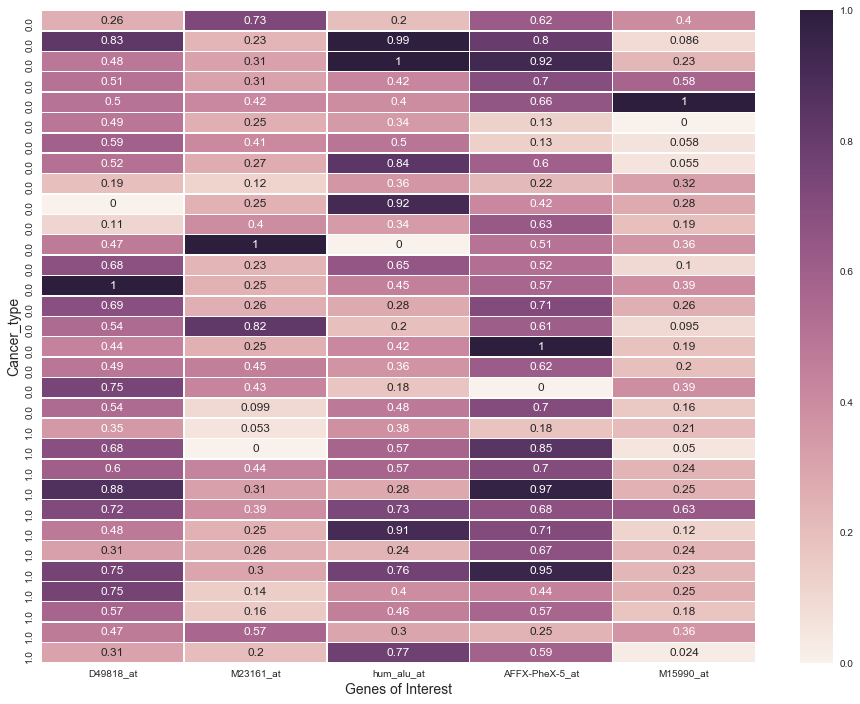

Mean of heatmap plotted genes grouped by 'Cancer_type':


,D49818_at,M23161_at,hum_alu_at,AFFX-PheX-5_at,M15990_at
Cancer_type,,,,,
0.0,0.504676,0.374248,0.465162,0.55364,0.266351
1.0,0.573192,0.255162,0.530630,0.62931,0.231240


In [6]:
#  Arrange the rows of the training set so that the 'AML' rows are grouped 
#  together and the 'ALL' rows are together.
#  Generate a heat map of the data with expression values from the following genes:  
#      D49818_at, M23161_at, hum_alu_at, AFFX-PheX-5_at, M15990_at. 

import seaborn as sns

plt.figure(figsize=(16, 12))

hm_columns = ['Cancer_type', 'D49818_at', 'M23161_at', 'hum_alu_at', 'AFFX-PheX-5_at', 'M15990_at']

#  Group rows by 'Cancer_type' 

Xtrain_hm = Xtrain[hm_columns].sort_values('Cancer_type')

#  Set row index to 'Cancer_type' for heat map plotting purposes
Xtrain_hm.set_index('Cancer_type', inplace=True)

#  Generate heat map, label cells with standardized gene expression value
ax = sns.heatmap(Xtrain_hm, annot=True, linewidths = .5)
ax.set_ylabel('Cancer_type', fontsize = 14)
ax.set_xlabel("Genes of Interest", fontsize = 14)
plt.show()

#  Output mean for each of these genes grouped by 'Cancer_type'
print ("Mean of heatmap plotted genes grouped by 'Cancer_type':")
Xtrain.groupby(['Cancer_type'])['D49818_at', 'M23161_at', 'hum_alu_at', 'AFFX-PheX-5_at', 'M15990_at'].mean()

In [7]:
#Find the top two principal components for the gene expression data. 
pca = PCA(n_components = 2)
X2 = pca.fit_transform(Xtrain[Xtrain.columns.difference(['Cancer_type'])])

dfpca = pd.DataFrame({"target":Xtrain.Cancer_type})
dfpca['pc1'] = X2[:,0]
dfpca['pc2'] = X2[:,1]
dfpca.head()

,target,pc1,pc2
0,0.0,7.667012,-0.181414
1,0.0,-8.705269,-3.125841
2,0.0,21.341975,8.695756
3,0.0,11.527633,23.669014
4,0.0,-7.842507,7.473386


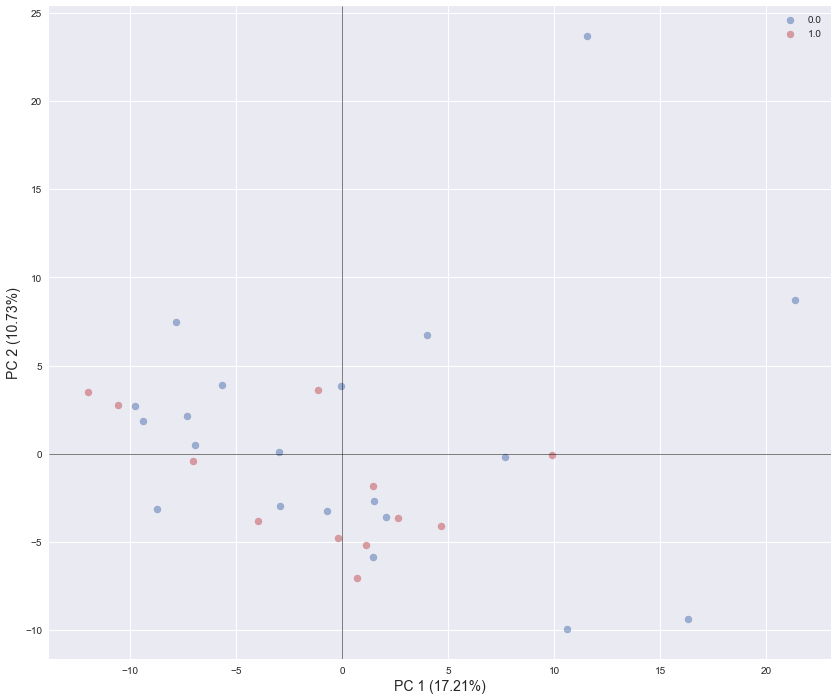

In [8]:
#Generate a scatter plot using these principal components, highlighting the AML and ALL points in different colors. 
c0=sns.color_palette()[0]; c2=sns.color_palette()[2]
colors = [c0, c2]
plt.figure(figsize=(14, 12))
#
for label, color in zip(dfpca['target'].unique(), colors):
    mask = dfpca['target']==label
    plt.scatter(dfpca[mask]['pc1'], 
                dfpca[mask]['pc2'], 
                c = color, 
                label = label, 
                alpha = 0.5,
                s = 50)
    
# Add the axis labels
plt.xlabel('PC 1 (%.2f%%)' % (pca.explained_variance_ratio_[0]*100), fontsize = 14)
plt.ylabel('PC 2 (%.2f%%)' % (pca.explained_variance_ratio_[1]*100), fontsize = 14)
plt.axhline(y = 0, color = 'k', linewidth = 0.5)
plt.axvline(x = 0, color = 'k', linewidth = 0.5)
plt.legend()

#### Notice that the results training set contains more predictors than observations. Do you foresee a problem in fitting a classification model to such a data set?

A:  Yes, Because there are more significantly more dimensions (7129) than training samples (32), the model's predictive ability may exhibit high variance (overfitting). The interpretability of the model will suffer too. It will be more challenging, if not impossible, to easily ascertain the most important predictors of the model. 

#### By observing the heat map, comment on which of these genes are useful in discriminating between the two classes.

Comments:

#### How well do the top two principal components discriminate between the two classes?

A:

## Part (b): Linear Regression vs. Logistic Regression

Begin by analyzing the differences between using linear regression and logistic regression for classification. For this part, you shall work with a single gene predictor: `M23161_at`.

1. Fit a simple linear regression model to the training set using the single gene predictor `D29963_at`. We could interpret the scores predicted by regression model interpreted for a patient as an estimate of the probability that the patient has the `ALL` type cancer (class 1). Is there a problem with this interpretation?

2. The fitted linear regression model can be converted to a classification model (i.e. a model that predicts one of two binary labels 0 or 1) by classifying patients with predicted score greater than 0.5 into the `ALL` type (class 1), and the others into the `AML` type (class 0). Evaluate the classification accuracy (1 - misclassification rate) of the obtained classification model on both the training and test sets.

3. Next, fit a simple logistic regression model to the training set. How does the training and test calssification accuracy of this model compare with the linear regression model?  Remember, you need to set the regularization parameter for sklearn's logistic regression function to be a very large value in order not to regularize (use 'C=100000').

4. Plot the quantitative output from linear regression model and the probabilistic output from the logistic regression model (on the training set points) as a function of the gene predictor. Also, display the true binary response for the training set points in the same plot.
Based on these plots, does one of the models appear better suited for binary classification than the other? Explain.



In [9]:
# Fit a simple linear regression model to the training set using the 
# single gene predictor D29963_at. 
# Evaluate the classification accuracy on both the training and test sets.

from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix

Xtrain_D29963 = Xtrain['D29963_at'].reshape(-1, 1)
Xtest_D29963  = Xtest['D29963_at'].reshape(-1, 1)

linreg = LinearRegression().fit(Xtrain_D29963, ytrain)

preds_train = (linreg.predict(Xtrain_D29963))
preds_test  = (linreg.predict(Xtest_D29963))

print ("Train Classification accuracy is: " + str(accuracy_score(ytrain, np.round(preds_train))))
print ("\nTest Classification accuracy is: " + str(accuracy_score(ytest, np.round(preds_test))))
print ("\n\nTrain Confusion Matrix:")
print (confusion_matrix(ytrain, np.round(preds_train), labels=None))
print ("\nTest Confusion Matrix:")
print (confusion_matrix(ytest, np.round(preds_test), labels=None))

Train Classification accuracy is: 0.71875

Test Classification accuracy is: 0.853658536585


Train Confusion Matrix:
[[19  1]
 [ 8  4]]

Test Confusion Matrix:
[[27  1]
 [ 5  8]]


/Users/rmitchell/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  
/Users/rmitchell/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if __name__ == '__main__':


#### Is there a problem with this interpretation?

A:
    
    
#### Evaluate the classification accuracy (1 - misclassification rate) of the obtained classification model on both the training and test sets.

Observations:

#### How does the training and test calssification accuracy of this model compare with the linear regression model?  

A:


#### Based on these plots, does one of the models appear better suited for binary classification than the other? Explain.

A:

## Part (c): Multiple Logistic Regression

1. Next, fit a multiple logistic regression model with all the gene predictors from the data set.  How does the classification accuracy of this model compare with the models fitted in Part (b) with a single gene (on both the training and test sets)?  

2. "Use the `visualize_prob` from `HW5_functions.py` to visualize the probabilties predicted by the fitted multiple logistic regression model on both the training and test data sets. The function creates a visualization that places the data points on a vertical line based on the predicted probabilities, with the `ALL` and `AML` classes shown in different colors, and with the 0.5 threshold highlighted using a dotted horizontal line.  Is there a difference in the spread of probabilities in the training and test plots? Are there data points for which the predicted probability is close to 0.5? If so, what can you say about these points?"

In [10]:
# Remove the response variable from Xtrain and Xtest
Xtrain = Xtrain[Xtrain.columns.difference(['Cancer_type'])]
Xtest  = Xtest[Xtest.columns.difference(['Cancer_type'])]

In [11]:
# starter code
from HW5_functions import visualize_prob
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix


logreg = LogisticRegression().fit(Xtrain, ytrain)

train_preds = logreg.predict(Xtrain)

test_preds = logreg.predict(Xtest)

print ("\nMultiple Logistic Regression Train Classification accuracy is: " + 
       str(logreg.score(Xtrain, ytrain)))
print ("Multiple Logistic Regression Test Classification accuracy is:  " +
       str(logreg.score(Xtest, ytest)))

print ("\nMultiple Logistic Regression Train Confusion Matrix:")
print (confusion_matrix(ytrain, np.round(train_preds), labels=None))
print ("\nMultiple Logistic Regression Test Confusion Matrix:")
print (confusion_matrix(ytest, np.round(test_preds), labels=None))


Multiple Logistic Regression Train Classification accuracy is: 1.0
Multiple Logistic Regression Test Classification accuracy is:  0.878048780488

Multiple Logistic Regression Train Confusion Matrix:
[[20  0]
 [ 0 12]]

Multiple Logistic Regression Test Confusion Matrix:
[[28  0]
 [ 5  8]]


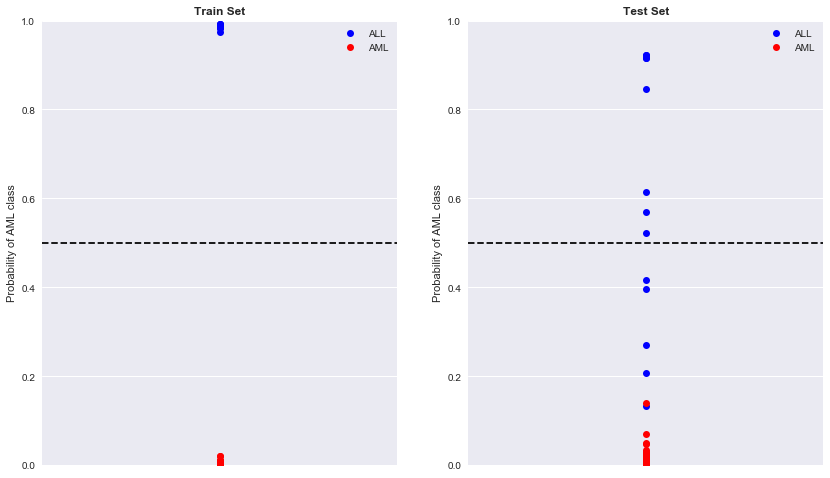

In [47]:
from HW5_functions import visualize_prob

fig = plt.figure(figsize=(14, 18))
ax = fig.add_subplot(221)
visualize_prob(logreg, Xtrain, ytrain, ax)
plt.title('Train Set', fontweight='bold')

ax = fig.add_subplot(222)
visualize_prob(logreg, Xtest, ytest, ax)
plt.title('Test Set', fontweight='bold')
plt.show()

#### Q: How does the classification accuracy of this model compare with the models fitted in Part (b) with a single gene (on both the training and test sets)?

This simple multi logistic regression is extremely overfitted. Because there are so many parameters, we are able to build a model that fits the training dataset perfectly. However, the score on the test set is lower than the score where just a single gene was considered.

####  Q: Is there a difference in the spread of probabilities in the training and test plots?

Yes, there is a significant difference in the spread of probabilities between the training and test plots.  The AML labeled training data is tightly clustered near probability 1.0 and the ALL labeled training data is tightly clustered near probability 0.0 in the training plot.

There is far greater spread of probabilities of AML and ALL labeled data in the test plot.  The AML labeled test data is spread out significantly across most of the probability range (~0.1 to 0.9) in the test plot instead of being tightly clustered near probability 1.0 in the training plot.  The ALL labeled test data is spread out more between probability 0.0 and 0.1.  While this is not nearly as much spread as the AML labeled test data, it is no longer tightly clustered as compared to the ALL labeled data in the training plot. 


    
#### Q: Are there data points for which the predicted probability is close to 0.5? 

Yes, in the test plot there are some AML labeled data points that whose probabilities are near 0.5 (0.4 - 0.6).
    
#### Q: If so, what can you say about these points?

Since these points are all AML labeled data points, it might be worthwhile to reduce the classification threshold for AML from 0.5.  From looking at the test plot, changing the threshold to 0.2 would most likely reduce misclassifation error.

## Part (d): Analyzing Significance of Coefficients

How many of the coefficients estimated by the multiple logistic regression in the previous problem are significantly different from zero at a *significance level of 95%*? 

Hint: To answer this question, use *bootstrapping* with 100 boostrap samples/iterations.  



In [45]:
from sklearn.utils import resample

coefficients = []
confidences = []
for i in range(100):
    Xtrain_sampled = resample(data_train, n_samples=100)
    ytrain_sampled = Xtrain_sampled['Cancer_type']
    Xtrain_sampled = Xtrain_sampled[Xtrain_sampled.columns.difference(['Cancer_type'])]
    logreg = LogisticRegression().fit(Xtrain_sampled, ytrain_sampled)
    coefficients.append(logreg.coef_[0])
    
coefficients = np.array(coefficients)
coefficients_df = pd.DataFrame(np.array(coefficients), columns = list(Xtrain.keys()))

coef_stats = coefficients_df.describe().transpose()
print(coef_stats.keys())
coef_stats['lower_95'] = coef_stats['mean'] - coef_stats['std']*2
coef_stats['upper_95'] = coef_stats['mean'] + coef_stats['std']*2
print(coef_stats.head)
coef_stats['significant'] = df.apply(lambda row: 1 if row['lower_95'] < 0 and row['upper_95'] > 0 else 1,axis=1)
coef_stats.head()



Index(['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], dtype='object')
<bound method NDFrame.head of                 count      mean       std       min       25%       50%  \
A28102_at       100.0  0.005455  0.003319 -0.002851  0.003447  0.005308   
AB000114_at     100.0 -0.028869  0.003298 -0.035406 -0.030715 -0.029398   
AB000115_at     100.0 -0.012639  0.002409 -0.017437 -0.014079 -0.012971   
AB000220_at     100.0 -0.019821  0.004125 -0.032467 -0.022454 -0.020122   
AB000381_s_at   100.0  0.000839  0.005382 -0.013120 -0.002100  0.001285   
AB000409_at     100.0 -0.008282  0.003134 -0.018268 -0.009844 -0.008302   
AB000410_s_at   100.0  0.001507  0.003601 -0.007792 -0.000356  0.001693   
AB000449_at     100.0 -0.020281  0.001699 -0.024066 -0.021457 -0.020357   
AB000450_at     100.0  0.009112  0.003071  0.000919  0.007249  0.009229   
AB000460_at     100.0 -0.004883  0.001650 -0.008616 -0.006054 -0.004896   
AB000462_at     100.0 -0.021852  0.003650 -0.030341 -0.024146 

KeyError: ('lower_95', 'occurred at index 0')

## Part (e): Dimensionality Reduction using PCA

A reasonable approach to reduce the dimensionality of the data is to use PCA and fit a logistic regression model on the first set of principal components contributing to 90% of the variance in the predictors.

1. How do the classification accuracy values on both the training and tests sets compare with the models fitted in Parts (c) and (d)?  

2. Re-fit a logistic regression model using 5-fold cross-validation to choose the number of principal components, and comment on whether you get better test performance than the model fitted above (explain your observations). 

3. Use the code provided in Part (c) to visualize the probabilities predicted by the fitted models on both the training and test sets. How does the spread of probabilities in these plots compare to those for the models in Part (c) and (d)? 


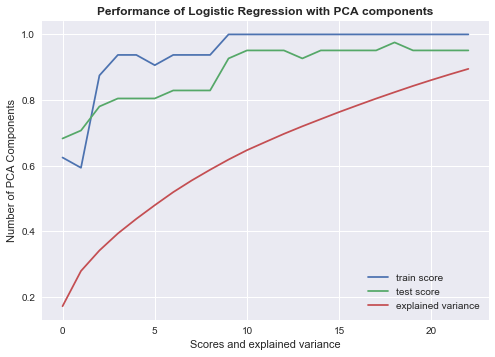

In [18]:

scores = {'train': [], 'test': []}
explainedVariances = []
for n_comp in range(1,24):
    pca = PCA(n_components = n_comp)
    pca.fit(Xtrain)
    explainedVariances.append(pca.explained_variance_ratio_.cumsum()[-1])
    Xtrain_pca = pca.transform(Xtrain)
    Xtest_pca = pca.transform(Xtest)
    logreg = LogisticRegression()
    logreg.fit(Xtrain_pca, ytrain)

    scores['train'].append(logreg.score(Xtrain_pca, ytrain))
    scores['test'].append(logreg.score(Xtest_pca, ytest))

plt.xlabel("Scores and explained variance")
plt.ylabel("Number of PCA Components")
plt.plot(scores['train'], label='train score')
plt.plot(scores['test'], label='test score')
plt.plot(explainedVariances, label='explained variance')
plt.title('Performance of Logistic Regression with PCA components', fontweight='bold')
plt.legend(loc='lower right')
plt.show()

    
     

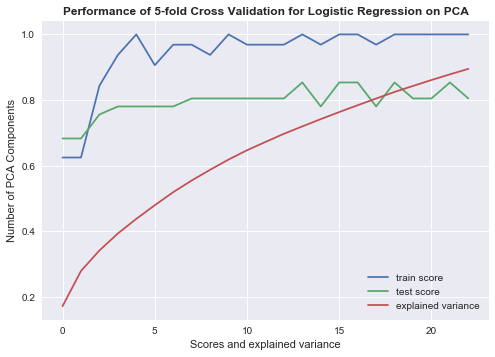

In [17]:
cv_scores = {'train': [], 'test': []}
cv_variances = []
for n_comp in range(1,24):
    pca = PCA(n_components = n_comp)
    pca.fit(Xtrain)
    cv_variances.append(pca.explained_variance_ratio_.cumsum()[-1])
    Xtrain_pca = pca.transform(Xtrain)
    Xtest_pca = pca.transform(Xtest)
    logreg = LogisticRegressionCV(cv=5)
    logreg.fit(Xtrain_pca, ytrain)

    cv_scores['train'].append(logreg.score(Xtrain_pca, ytrain))
    cv_scores['test'].append(logreg.score(Xtest_pca, ytest))

plt.xlabel("Scores and explained variance")
plt.ylabel("Number of PCA Components")
plt.plot(cv_scores['train'], label='train score')
plt.plot(cv_scores['test'], label='test score')
plt.plot(cv_variances, label='explained variance')
plt.title('Performance of 5-fold Cross Validation for Logistic Regression with PCA', fontweight='bold')
plt.legend(loc='lower right')
plt.show()


Best performance: 11


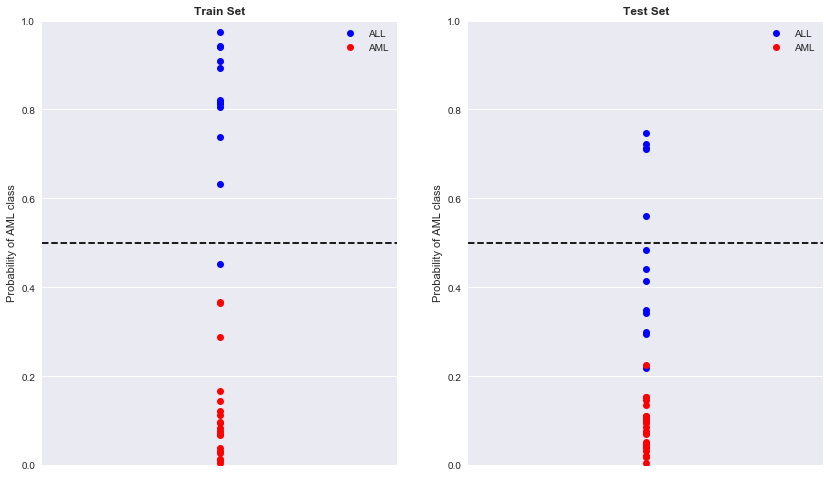

In [15]:
# Get the best num of PCA components based on 
# performance on the test data
best_n_comp = np.argmax(cv_scores['test']) + 1
print("Best performance: "+str(best_n_comp))
pca = PCA(n_components=best_n_comp)

pca.fit(Xtrain)
Xtrain_pca = pca.transform(Xtrain)
Xtest_pca = pca.transform(Xtest)

logreg = LogisticRegressionCV(cv=5)
logreg.fit(Xtrain_pca, ytrain)
    
fig = plt.figure(figsize=(14, 18))
ax = fig.add_subplot(221)
visualize_prob(logreg, Xtrain_pca, ytrain, ax)
plt.title('Train Set', fontweight='bold')

ax = fig.add_subplot(222)
visualize_prob(logreg, Xtest_pca, ytest, ax)
plt.title('Test Set', fontweight='bold')
plt.show()